For the given task I have used reverse image search using ResNet50 to create a vectorial search space and Nearest Neighors algorithm to find the nearest matching image

In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [2]:
img_size =224
model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

In [3]:
batch_size = 64
root_dir = 'img'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict(datagen, num_epochs)

Found 52712 images belonging to 2 classes.
824/824 [==============================] - 2029s 2s/step


In [11]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

Since Nearest Neighbours algorithm suffers from curse of dimentionality PCA is used to extract the relevant features which cuts down 2048 features as generated by the ResNet50 model to 100 features

In [12]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [13]:
neighbor = NearestNeighbors(n_neighbors=1,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

In [26]:
def test(img_path):
    input_shape = (img_size, img_size, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    test_img_features = model.predict(preprocessed_img, batch_size=1)
    test_img_compressed = pca.transform(test_img_features)
    distances, index = neighbor.kneighbors(test_img_compressed)
    print(index)
    plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
    plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
    plt.show()
    print('********* Predictions ***********')
    plt.imshow(mpimg.imread(filenames[index[0][0]]), interpolation='lanczos')   

Initially tested it with a image from the dataset it self and it was producing the right result

1/1 [==============================] - 0s 82ms/step
[[2544]]


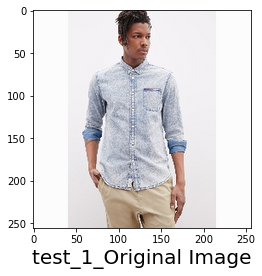

********* Predictions ***********


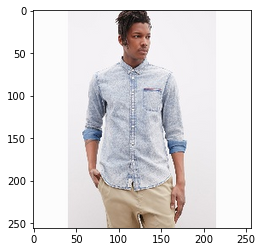

In [27]:
test("test_1.jpg")

Testing the model with an image from internet of a marron tshirt was indeed giving a marron tshirt of a similar style

1/1 [==============================] - 0s 85ms/step
[[7523]]


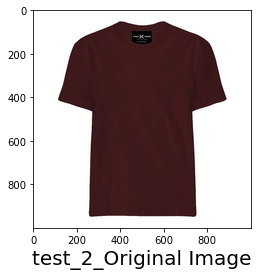

********* Predictions ***********


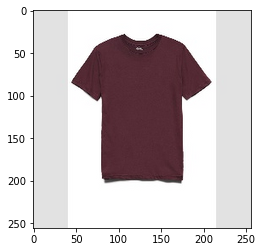

In [28]:
test("test_2.jpg")